In [19]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))

In [20]:
import math

In [21]:
from matplotlib import pyplot as plt
import pandas as pd

In [22]:
from pyfindata.common.ccy import Ccy
from pyfindata.common.ts_config import TSConfig
from pyfindata.extractor.configs import CsvDataFileConfig
from pyfindata.common.freq import Freq
from pyfindata.common.constants import DEFAULT_DATA_PATH
from pyfindata.pipeline.get_merged_stooq_data_pipeline import GetMergedStooqDataPipeline

In [23]:
import logging

In [24]:
logger = logging.getLogger("financial-assets-adj-for-inflation")
logger.setLevel(logging.INFO)

In [37]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## 1. Load Financial Assets' Prices & Calculate Nominal Price Index Anchored at Dec2019 

In [25]:
ts_configs: list[TSConfig] = [
    TSConfig(ticker="apple", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="btc", ccy=Ccy.PLN, freq=Freq.DAILY),
    TSConfig(ticker="dax", ccy=Ccy.EUR, freq=Freq.DAILY),
    TSConfig(ticker="eth", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="eurpln", ccy=Ccy.PLN, freq=Freq.DAILY),
    TSConfig(ticker="nasdaq", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="nvidia", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="sp500", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="tesla", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="tsmc", ccy=Ccy.USD, freq=Freq.DAILY),
    TSConfig(ticker="usdpln", ccy=Ccy.PLN, freq=Freq.DAILY),
    TSConfig(ticker="xaupln", ccy=Ccy.PLN, freq=Freq.DAILY),
]

In [26]:
csv_configs: list[CsvDataFileConfig] = [
    CsvDataFileConfig(ts_config=ts_config, filepath=(DEFAULT_DATA_PATH / f"{ts_config.ticker}_{ts_config.ccy.value}.csv"))
    for ts_config in ts_configs
]

In [27]:
pipeline = GetMergedStooqDataPipeline(csv_configs=csv_configs)
data = pipeline.execute()

2025-01-11 22:09:07,387 - pyfindata.pipeline.get_merged_stooq_data_pipeline - INFO - Extracting Stooq data from CSV files
2025-01-11 22:09:07,388 - pyfindata.extractor.stooq_csv_extractor - INFO - Extracting & processing data from file /Users/wegar/github_repos/pyfindata/data/apple_usd.csv
2025-01-11 22:09:07,405 - pyfindata.extractor.stooq_csv_extractor - INFO - Extracting & processing data from file /Users/wegar/github_repos/pyfindata/data/btc_pln.csv
2025-01-11 22:09:07,412 - pyfindata.extractor.stooq_csv_extractor - INFO - Extracting & processing data from file /Users/wegar/github_repos/pyfindata/data/dax_eur.csv
2025-01-11 22:09:07,435 - pyfindata.extractor.stooq_csv_extractor - INFO - Extracting & processing data from file /Users/wegar/github_repos/pyfindata/data/eth_usd.csv
2025-01-11 22:09:07,451 - pyfindata.extractor.stooq_csv_extractor - INFO - Extracting & processing data from file /Users/wegar/github_repos/pyfindata/data/eurpln_pln.csv
2025-01-11 22:09:07,463 - pyfindata.ex

In [28]:
data = data.loc["2016-01-01":, :]
data.columns = data.columns.droplevel(level=1)

In [29]:
assets = ["btc", "xaupln", "dax", "apple", "eth", "nasdaq", "nvidia", "sp500", "tesla", "tsmc"]

In [30]:
data = data[assets]

In [31]:
def geometric_mean(numbers):
    product = math.prod(numbers)
    n = len(numbers)
    return product ** (1 / n)

In [32]:
dec2019 = data.loc["2019-12-01":"2019-12-31", :]

In [33]:
dec2019_gms = dec2019.groupby(pd.Grouper(freq="m")).agg(geometric_mean)

/var/folders/pn/mflr608s6vdbf4ccdqtxcldw0000gn/T/ipykernel_29969/2060732104.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dec2019_gms = dec2019.groupby(pd.Grouper(freq="m")).agg(geometric_mean)


In [34]:
assets_nominal_index = data.div(dec2019_gms.values)

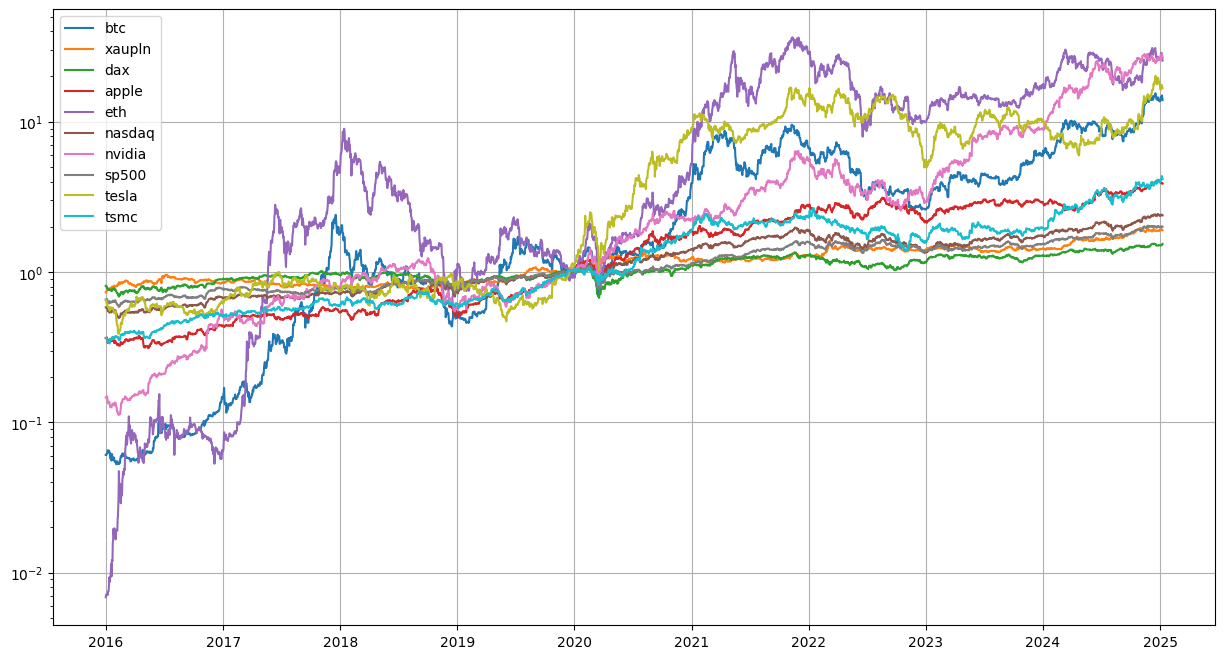

In [39]:
fig_nai = plt.figure(figsize=(15, 8))
ax_nai = fig_nai.add_subplot(1, 1, 1)
for asset in assets:
    ax_nai.plot(assets_nominal_index[asset], label=asset)
ax_nai.grid()
ax_nai.set_yscale("log")
ax_nai.legend()

## 2. Load Data 

In [40]:
from pyfindata.extractor.gus_monthly_macro_indicators_extractor import GUSMonthlyMacroIndicatorsExtractor

In [47]:
# load inflation dat
inflation = GUSMonthlyMacroIndicatorsExtractor().extract()
inflation = inflation.loc[~inflation.isna().any(axis=1), :]

/Users/wegar/github_repos/pyfindata/pyfindata/extractor/gus_monthly_macro_indicators_extractor.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_index["year"] = data_index["year"].ffill(axis=0).astype(np.int64)


In [48]:
# get price index anchored at Dec 2019
inflation = inflation[["CPI_MoM", "yearmon"]].set_index("yearmon")
inflation["price_index"] = (inflation["CPI_MoM"] / 100).cumprod()
inflation["price_index"] = inflation["price_index"] / inflation.loc["2019-12-01", "price_index"]
inflation = inflation["2011-01-01":]

In [49]:
inflation = inflation[["price_index"]]

In [57]:
ari = pd.merge_asof(left=assets_nominal_index, right=inflation, direction="backward", left_index=True, right_index=True)

In [58]:
for asset in assets:
    ari[asset] = ari[asset] / ari["price_index"]
ari = ari.drop(columns=["price_index"])

In [59]:
ari.tail()

,btc,xaupln,dax,apple,eth,nasdaq,nvidia,sp500,tesla,tsmc
Date,,,,,,,,,,
2025-01-04,10.120533,1.330048,1.042475,2.705758,19.913974,1.667032,19.223417,1.395393,12.195731,2.893466
2025-01-05,10.120533,1.330048,1.042475,2.705758,19.835398,1.667032,19.223417,1.395393,12.195731,2.893466
2025-01-06,10.383408,1.314139,1.054931,2.692356,19.791502,1.668102,19.652479,1.386825,12.072006,3.016146
2025-01-07,9.934346,1.314139,1.062931,2.677626,18.376701,1.646382,18.541002,1.379634,11.651161,2.915732
2025-01-08,9.651361,1.314139,1.065829,2.68786,17.663313,1.649856,18.500187,1.385136,11.60215,2.870775


Text(0.5, 1.0, "Select assets' real prices in PLN, indexed to Dec 2019")

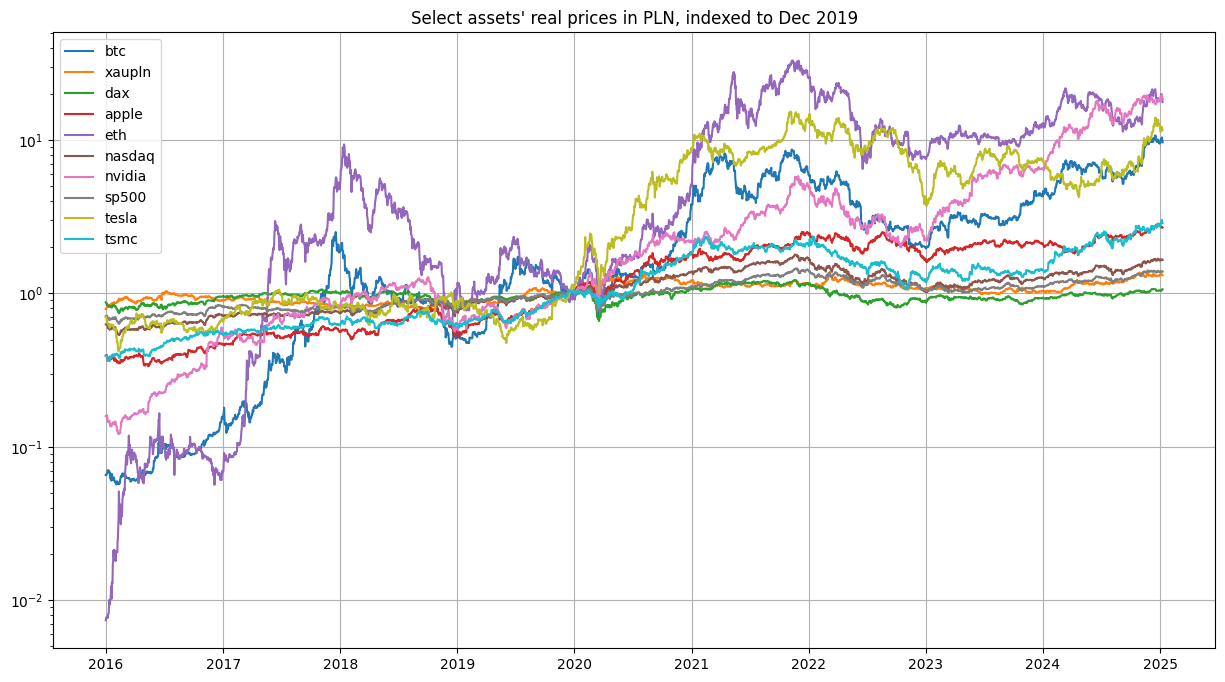

In [63]:
fig_ari = plt.figure(figsize=(15, 8))
ax_ari = fig_ari.add_subplot(1, 1, 1)
for asset in assets:
    ax_ari.plot(ari[asset], label=asset)
ax_ari.grid()
ax_ari.legend()
ax_ari.set_yscale("log")
ax_ari.set_title("Select assets' real prices in PLN, indexed to Dec 2019")